In [445]:
'RNN with Attention Mechanism'

# Data Prep
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Layer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# Custom Attention Layer with Feature Masking
class AttentionLayer(Layer):
    def __init__(self, target_feature_index, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.target_feature_index = target_feature_index

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)

        # Apply a mask to reduce the influence of the target variable
        mask = np.ones(x.shape[2])  # Assuming the last dimension is features
        mask[self.target_feature_index] = 1  # Reduce the weight of the target variable
        mask = tf.constant(mask, dtype=tf.float32)
        e *= mask

        alpha = tf.nn.softmax(e, axis=1)
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context
    
# Load and preprocess the data
file_path = '2023_RNN_Input_Sequence.xlsx'
df = pd.read_excel(file_path)
df.drop(columns=['Date'], inplace=True)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['Hashrate', 'Reward', 'Difficulty']])
target = np.full(shape=(len(df),), fill_value=(81.75 * 365) / 365) 

time_steps = 1
X_reshaped = scaled_features.reshape((scaled_features.shape[0], time_steps, scaled_features.shape[1]))
y = target.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=0)


In [446]:
# RNN Model with Attention
model_rnn = Sequential()
model_rnn.add(SimpleRNN(32, activation='relu', return_sequences=True, input_shape=(time_steps, 3)))
model_rnn.add(AttentionLayer(target_feature_index=0))  # Assuming the first feature is to be masked
model_rnn.add(Dense(16, activation='relu'))
model_rnn.add(Dense(1))

optimizer = Adam(learning_rate=0.0002)
model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')


In [447]:
# Custom EarlyStopping Callback
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        print(f"Epoch {epoch}, Current Loss: {current_loss}")
        if current_loss is not None and current_loss <= 0.5 and current_loss >= 0.3:
            print("Stopping training...")
            self.model.stop_training = True

# Custom Early Stopping callback definition
custom_early_stopping = CustomEarlyStopping()

# Training the Model with Custom Early Stopping
history_rnn = model_rnn.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=16, callbacks=[custom_early_stopping])

# Model Evaluation
model_rnn.evaluate(X_val, y_val)

Epoch 1/1000
19/19 [==============================] - 2s 16ms/step - loss: 6677.9683 - val_loss: 6674.5474
Epoch 2/1000
19/19 [==============================] - 0s 3ms/step - loss: 6671.1021 - val_loss: 6667.7744
Epoch 3/1000
19/19 [==============================] - 0s 4ms/step - loss: 6663.9229 - val_loss: 6661.2031
Epoch 4/1000
19/19 [==============================] - 0s 4ms/step - loss: 6656.8135 - val_loss: 6654.6470
Epoch 5/1000
19/19 [==============================] - 0s 4ms/step - loss: 6649.6797 - val_loss: 6647.8027
Epoch 6/1000
19/19 [==============================] - 0s 3ms/step - loss: 6642.1162 - val_loss: 6640.3296
Epoch 7/1000
19/19 [==============================] - 0s 3ms/step - loss: 6633.5054 - val_loss: 6630.5640
Epoch 8/1000
19/19 [==============================] - 0s 3ms/step - loss: 6621.1489 - val_loss: 6617.0947
Epoch 9/1000
19/19 [==============================] - 0s 3ms/step - loss: 6606.3350 - val_loss: 6602.8716
Epoch 10/1000
19/19 [========================

Epoch 40/1000
19/19 [==============================] - 0s 3ms/step - loss: 4839.5952 - val_loss: 4898.5918
Epoch 41/1000
19/19 [==============================] - 0s 3ms/step - loss: 4737.4565 - val_loss: 4801.5737
Epoch 42/1000
19/19 [==============================] - 0s 3ms/step - loss: 4633.8057 - val_loss: 4701.2285
Epoch 43/1000
19/19 [==============================] - 0s 3ms/step - loss: 4527.8770 - val_loss: 4600.4897
Epoch 44/1000
19/19 [==============================] - 0s 3ms/step - loss: 4420.8022 - val_loss: 4497.9614
Epoch 45/1000
19/19 [==============================] - 0s 3ms/step - loss: 4312.0449 - val_loss: 4393.8257
Epoch 46/1000
19/19 [==============================] - 0s 3ms/step - loss: 4202.0454 - val_loss: 4288.3750
Epoch 47/1000
19/19 [==============================] - 0s 3ms/step - loss: 4090.4954 - val_loss: 4181.8984
Epoch 48/1000
19/19 [==============================] - 0s 3ms/step - loss: 3978.3120 - val_loss: 4073.9966
Epoch 49/1000
19/19 [================

19/19 [==============================] - 0s 3ms/step - loss: 1090.5436 - val_loss: 1222.8429
Epoch 79/1000
19/19 [==============================] - 0s 3ms/step - loss: 1035.2959 - val_loss: 1161.9756
Epoch 80/1000
19/19 [==============================] - 0s 3ms/step - loss: 982.2229 - val_loss: 1105.3439
Epoch 81/1000
19/19 [==============================] - 0s 3ms/step - loss: 932.8307 - val_loss: 1052.9374
Epoch 82/1000
19/19 [==============================] - 0s 3ms/step - loss: 886.9692 - val_loss: 1002.9834
Epoch 83/1000
19/19 [==============================] - 0s 2ms/step - loss: 844.0701 - val_loss: 953.4916
Epoch 84/1000
19/19 [==============================] - 0s 3ms/step - loss: 802.4877 - val_loss: 908.6679
Epoch 85/1000
19/19 [==============================] - 0s 3ms/step - loss: 765.2114 - val_loss: 865.2568
Epoch 86/1000
19/19 [==============================] - 0s 3ms/step - loss: 729.2245 - val_loss: 825.6213
Epoch 87/1000
19/19 [==============================] - 0s 3ms/

Epoch 117/1000
19/19 [==============================] - 0s 3ms/step - loss: 391.4065 - val_loss: 364.3447
Epoch 118/1000
19/19 [==============================] - 0s 3ms/step - loss: 389.3942 - val_loss: 360.4256
Epoch 119/1000
19/19 [==============================] - 0s 2ms/step - loss: 387.4243 - val_loss: 357.5566
Epoch 120/1000
19/19 [==============================] - 0s 3ms/step - loss: 385.5991 - val_loss: 355.0776
Epoch 121/1000
19/19 [==============================] - 0s 2ms/step - loss: 383.8061 - val_loss: 352.2109
Epoch 122/1000
19/19 [==============================] - 0s 3ms/step - loss: 382.2252 - val_loss: 350.2612
Epoch 123/1000
19/19 [==============================] - 0s 3ms/step - loss: 380.2033 - val_loss: 346.0214
Epoch 124/1000
19/19 [==============================] - 0s 3ms/step - loss: 378.2946 - val_loss: 343.3185
Epoch 125/1000
19/19 [==============================] - 0s 3ms/step - loss: 376.4624 - val_loss: 340.6590
Epoch 126/1000
19/19 [========================

19/19 [==============================] - 0s 3ms/step - loss: 323.3717 - val_loss: 283.7397
Epoch 156/1000
19/19 [==============================] - 0s 3ms/step - loss: 321.6371 - val_loss: 283.7477
Epoch 157/1000
19/19 [==============================] - 0s 3ms/step - loss: 319.6359 - val_loss: 281.6178
Epoch 158/1000
19/19 [==============================] - 0s 3ms/step - loss: 317.8110 - val_loss: 279.5682
Epoch 159/1000
19/19 [==============================] - 0s 3ms/step - loss: 316.1316 - val_loss: 276.8614
Epoch 160/1000
19/19 [==============================] - 0s 2ms/step - loss: 314.1201 - val_loss: 275.8305
Epoch 161/1000
19/19 [==============================] - 0s 2ms/step - loss: 312.3009 - val_loss: 275.1895
Epoch 162/1000
19/19 [==============================] - 0s 3ms/step - loss: 310.4055 - val_loss: 274.1203
Epoch 163/1000
19/19 [==============================] - 0s 3ms/step - loss: 308.7133 - val_loss: 273.6462
Epoch 164/1000
19/19 [==============================] - 0s 3m

19/19 [==============================] - 0s 3ms/step - loss: 251.5762 - val_loss: 219.7050
Epoch 194/1000
19/19 [==============================] - 0s 3ms/step - loss: 249.5229 - val_loss: 217.1947
Epoch 195/1000
19/19 [==============================] - 0s 2ms/step - loss: 247.5402 - val_loss: 216.4992
Epoch 196/1000
19/19 [==============================] - 0s 3ms/step - loss: 245.6356 - val_loss: 213.9870
Epoch 197/1000
19/19 [==============================] - 0s 3ms/step - loss: 243.7678 - val_loss: 212.2321
Epoch 198/1000
19/19 [==============================] - 0s 3ms/step - loss: 241.7684 - val_loss: 210.3191
Epoch 199/1000
19/19 [==============================] - 0s 3ms/step - loss: 239.8794 - val_loss: 208.2809
Epoch 200/1000
19/19 [==============================] - 0s 3ms/step - loss: 237.8801 - val_loss: 207.3324
Epoch 201/1000
19/19 [==============================] - 0s 3ms/step - loss: 235.9297 - val_loss: 205.0805
Epoch 202/1000
19/19 [==============================] - 0s 3m

19/19 [==============================] - 0s 3ms/step - loss: 178.8347 - val_loss: 153.5150
Epoch 232/1000
19/19 [==============================] - 0s 3ms/step - loss: 177.0684 - val_loss: 151.3184
Epoch 233/1000
19/19 [==============================] - 0s 3ms/step - loss: 175.1866 - val_loss: 150.2000
Epoch 234/1000
19/19 [==============================] - 0s 3ms/step - loss: 173.3829 - val_loss: 148.7148
Epoch 235/1000
19/19 [==============================] - 0s 3ms/step - loss: 171.5937 - val_loss: 146.6470
Epoch 236/1000
19/19 [==============================] - 0s 2ms/step - loss: 169.7648 - val_loss: 145.1864
Epoch 237/1000
19/19 [==============================] - 0s 3ms/step - loss: 167.9854 - val_loss: 144.6783
Epoch 238/1000
19/19 [==============================] - 0s 3ms/step - loss: 166.1126 - val_loss: 142.9889
Epoch 239/1000
19/19 [==============================] - 0s 3ms/step - loss: 164.2872 - val_loss: 141.3199
Epoch 240/1000
19/19 [==============================] - 0s 3m

19/19 [==============================] - 0s 3ms/step - loss: 112.1435 - val_loss: 95.1030
Epoch 270/1000
19/19 [==============================] - 0s 3ms/step - loss: 110.5138 - val_loss: 94.1199
Epoch 271/1000
19/19 [==============================] - 0s 3ms/step - loss: 108.9219 - val_loss: 93.1979
Epoch 272/1000
19/19 [==============================] - 0s 3ms/step - loss: 107.3398 - val_loss: 91.2437
Epoch 273/1000
19/19 [==============================] - 0s 3ms/step - loss: 105.7673 - val_loss: 90.0838
Epoch 274/1000
19/19 [==============================] - 0s 3ms/step - loss: 104.1438 - val_loss: 88.4729
Epoch 275/1000
19/19 [==============================] - 0s 3ms/step - loss: 102.6577 - val_loss: 86.9063
Epoch 276/1000
19/19 [==============================] - 0s 3ms/step - loss: 101.1853 - val_loss: 86.0785
Epoch 277/1000
19/19 [==============================] - 0s 3ms/step - loss: 99.5732 - val_loss: 84.6630
Epoch 278/1000
19/19 [==============================] - 0s 3ms/step - l

Epoch 308/1000
19/19 [==============================] - 0s 3ms/step - loss: 57.2662 - val_loss: 48.4368
Epoch 309/1000
19/19 [==============================] - 0s 3ms/step - loss: 56.0743 - val_loss: 47.4341
Epoch 310/1000
19/19 [==============================] - 0s 3ms/step - loss: 54.9178 - val_loss: 46.4266
Epoch 311/1000
19/19 [==============================] - 0s 3ms/step - loss: 53.8082 - val_loss: 45.0328
Epoch 312/1000
19/19 [==============================] - 0s 3ms/step - loss: 52.6366 - val_loss: 44.1575
Epoch 313/1000
19/19 [==============================] - 0s 3ms/step - loss: 51.5467 - val_loss: 43.5371
Epoch 314/1000
19/19 [==============================] - 0s 3ms/step - loss: 50.4984 - val_loss: 42.6282
Epoch 315/1000
19/19 [==============================] - 0s 3ms/step - loss: 49.3596 - val_loss: 41.9880
Epoch 316/1000
19/19 [==============================] - 0s 3ms/step - loss: 48.2699 - val_loss: 41.0412
Epoch 317/1000
19/19 [==============================] - 0s 3ms/s

Epoch 347/1000
19/19 [==============================] - 0s 3ms/step - loss: 21.2470 - val_loss: 18.0671
Epoch 348/1000
19/19 [==============================] - 0s 3ms/step - loss: 20.6086 - val_loss: 17.5870
Epoch 349/1000
19/19 [==============================] - 0s 3ms/step - loss: 19.9889 - val_loss: 17.0779
Epoch 350/1000
19/19 [==============================] - 0s 3ms/step - loss: 19.3391 - val_loss: 16.4667
Epoch 351/1000
19/19 [==============================] - 0s 3ms/step - loss: 18.7424 - val_loss: 15.9688
Epoch 352/1000
19/19 [==============================] - 0s 3ms/step - loss: 18.1554 - val_loss: 15.4660
Epoch 353/1000
19/19 [==============================] - 0s 3ms/step - loss: 17.5204 - val_loss: 14.8402
Epoch 354/1000
19/19 [==============================] - 0s 3ms/step - loss: 16.9826 - val_loss: 14.3938
Epoch 355/1000
19/19 [==============================] - 0s 3ms/step - loss: 16.3873 - val_loss: 13.9107
Epoch 356/1000
19/19 [==============================] - 0s 2ms/s

19/19 [==============================] - 0s 3ms/step - loss: 4.8878 - val_loss: 4.3169
Epoch 387/1000
19/19 [==============================] - 0s 3ms/step - loss: 4.6695 - val_loss: 4.1207
Epoch 388/1000
19/19 [==============================] - 0s 3ms/step - loss: 4.4844 - val_loss: 3.8729
Epoch 389/1000
19/19 [==============================] - 0s 3ms/step - loss: 4.2811 - val_loss: 3.7558
Epoch 390/1000
19/19 [==============================] - 0s 2ms/step - loss: 4.1029 - val_loss: 3.5874
Epoch 391/1000
19/19 [==============================] - 0s 3ms/step - loss: 3.9283 - val_loss: 3.4817
Epoch 392/1000
19/19 [==============================] - 0s 3ms/step - loss: 3.7560 - val_loss: 3.2881
Epoch 393/1000
19/19 [==============================] - 0s 3ms/step - loss: 3.5931 - val_loss: 3.1694
Epoch 394/1000
19/19 [==============================] - 0s 3ms/step - loss: 3.4356 - val_loss: 3.0006
Epoch 395/1000
19/19 [==============================] - 0s 2ms/step - loss: 3.2901 - val_loss: 2.

Epoch 426/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.8901 - val_loss: 0.7148
Epoch 427/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.8587 - val_loss: 0.6897
Epoch 428/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.8310 - val_loss: 0.6653
Epoch 429/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.8044 - val_loss: 0.6379
Epoch 430/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.7809 - val_loss: 0.6085
Epoch 431/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.7554 - val_loss: 0.5935
Epoch 432/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.7356 - val_loss: 0.5775
Epoch 433/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.7114 - val_loss: 0.5451
Epoch 434/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.6934 - val_loss: 0.5204
Epoch 435/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.6738

0.33137738704681396

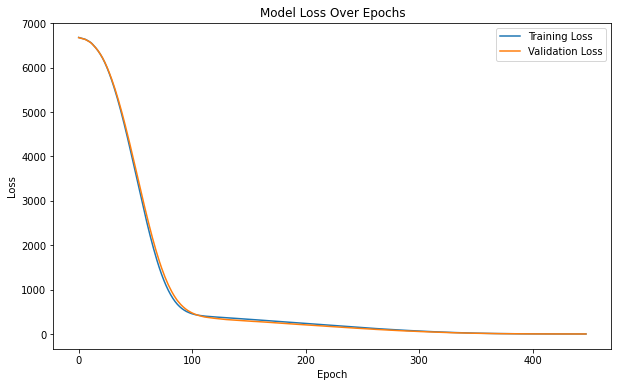

In [448]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


3/3 [==============================] - 0s 2ms/step


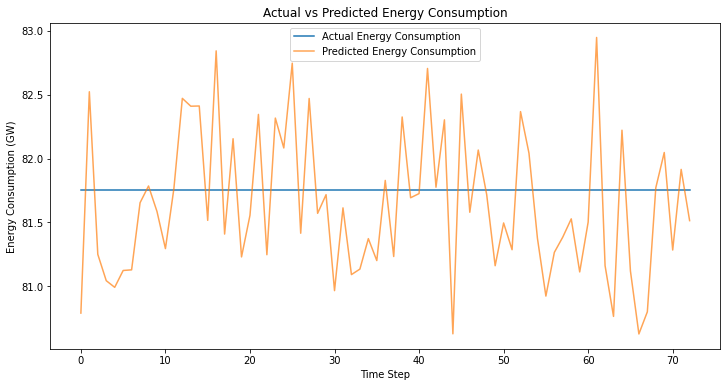

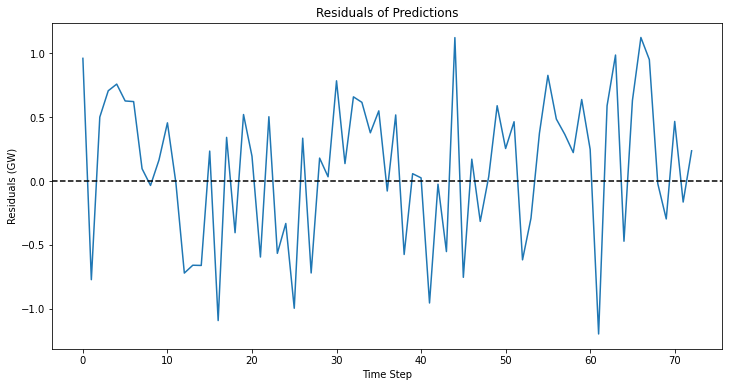

In [449]:
# Predict and Plot Actual vs Predicted
predicted_values_rnn = model_rnn.predict(X_val)
y_val_flattened = y_val.flatten()
predicted_values_rnn_flattened = predicted_values_rnn.flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_val_flattened, label='Actual Energy Consumption')
plt.plot(predicted_values_rnn_flattened, label='Predicted Energy Consumption', alpha=0.7)
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption (GW)')
plt.legend()
plt.show()
# Residuals Plot
residuals_rnn = y_val_flattened - predicted_values_rnn_flattened
plt.figure(figsize=(12, 6))
plt.plot(residuals_rnn)
plt.title('Residuals of Predictions')
plt.xlabel('Time Step')
plt.ylabel('Residuals (GW)')
plt.axhline(y=0, linestyle='--', color='black')
plt.show()


12/12 [==============================] - 0s 1ms/step


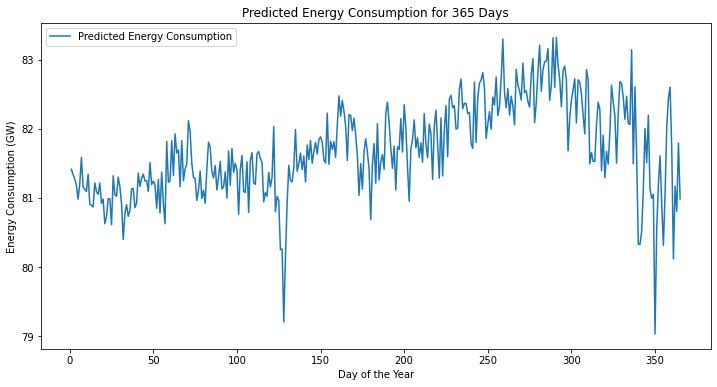

In [450]:
# Full Series Prediction and Plotting
X_full = scaled_features.reshape((scaled_features.shape[0], time_steps, scaled_features.shape[1]))
full_predictions = model_rnn.predict(X_full)
full_predictions_flattened = full_predictions.flatten()

# Plot Full Series
df_full_series = pd.DataFrame({
    'Day': range(1, 366),
    'Predicted Energy Consumption': full_predictions_flattened
})

plt.figure(figsize=(12, 6))
plt.plot(df_full_series['Day'], df_full_series['Predicted Energy Consumption'], label='Predicted Energy Consumption')
plt.title('Predicted Energy Consumption for 365 Days')
plt.xlabel('Day of the Year')
plt.ylabel('Energy Consumption (GW)')
plt.legend()
plt.show()


In [451]:
# Variance of Predictions on Validation Set
variance_val_predictions = np.var(predicted_values_rnn_flattened)
print("Variance of Validation Set Predictions:", variance_val_predictions)

# Variance of Predictions on Full Dataset
variance_full_predictions = np.var(full_predictions_flattened)
print("Variance of Full Dataset Predictions:", variance_full_predictions)


Variance of Validation Set Predictions: 0.31993416
Variance of Full Dataset Predictions: 0.4511423


12/12 [==============================] - 0s 1ms/step


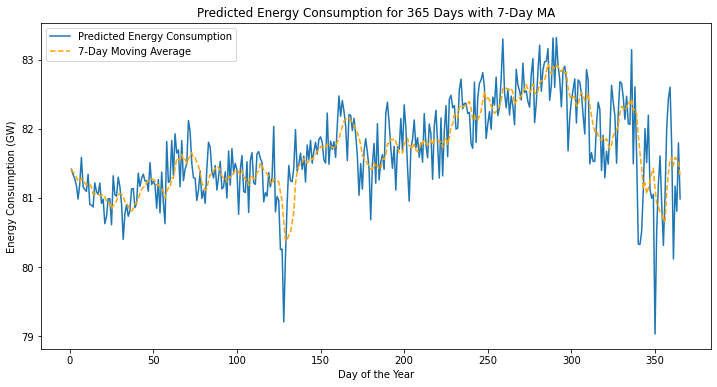

In [452]:
# Full Series Prediction and Plotting
X_full = scaled_features.reshape((scaled_features.shape[0], time_steps, scaled_features.shape[1]))
full_predictions = model_rnn.predict(X_full)
full_predictions_flattened = full_predictions.flatten()

# Calculate 7-Day Moving Average
df_full_series = pd.DataFrame({
    'Day': range(1, 366),
    'Predicted Energy Consumption': full_predictions_flattened
})
df_full_series['7-Day MA'] = df_full_series['Predicted Energy Consumption'].rolling(window=7, min_periods=1).mean()

# Plot Full Series and 7-Day Moving Average
plt.figure(figsize=(12, 6))
plt.plot(df_full_series['Day'], df_full_series['Predicted Energy Consumption'], label='Predicted Energy Consumption')
plt.plot(df_full_series['Day'], df_full_series['7-Day MA'], label='7-Day Moving Average', color='orange', linestyle='--')
plt.title('Predicted Energy Consumption for 365 Days with 7-Day MA')
plt.xlabel('Day of the Year')
plt.ylabel('Energy Consumption (GW)')
plt.legend()
plt.show()


In [453]:
# Export to CSV
csv_file_path = '2023_D_CO2_RNN_AM_full_pred.csv'
df_full_series.to_csv(csv_file_path, index=False)